In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as ppf
import datetime
import string
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.patches as mpatches

#plotly output mode
init_notebook_mode(connected=True)
#matplotlib display in notebook
%matplotlib inline
#seaborn style
sns.set(style='whitegrid', palette='muted', color_codes=True)

In [2]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, log_loss

In [3]:
stopwords_set = set(stopwords.words('english'))
s = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

def text_process(comment_column):
    filtered_rows = []
    for rows in comment_column:
        only_words = tokenizer.tokenize(rows)
        no_stopwords = [word for word in only_words if word.lower() not in stopwords_set]
        #stems = [s.stem(word) for word in no_stopwords]
        filtered_rows.append(' '.join(no_stopwords))
    return filtered_rows

def find_badwords(comment_column):
    filtered_rows = []
    for rows in comment_column:
        only_words = tokenizer.tokenize(rows)
        bad = [word for word in only_words if word.lower() in badwords_set]
        total_bad,=np.shape(bad)
        filtered_rows.append(total_bad)
    return filtered_rows

def get_tags(df):
    tags=[]
    alltags=[]
    rows = df.shape[0]
    for r in range(df.index.min(),df.index.max()+1):
        for f in df.columns:
            if df.loc[r,f] == 1:
                tags.append(str(f))
        alltags.append(tags)
        tags=[]
    return alltags

In [4]:
df_train_initial = pd.read_csv('train.csv.zip')
df_test_initial = pd.read_csv('test.csv.zip')
df_features=pd.concat([df_train_initial,df_test_initial]).reset_index(drop=True)
df_features['source'] = ''
df_features.loc[0:len(df_train_initial),['source']] = 'train'
df_features.loc[len(df_train_initial):,['source']] = 'test'

initialcols = list(df_train_initial.columns[df_train_initial.dtypes == 'int64'])

punct_set = set(string.punctuation)

badwords = pd.read_csv('badwords.txt',header=None)
badwords.rename(columns={0:'badwords'},inplace=True)
badwords['badwords'] = badwords['badwords'].str.lower()
badwords_set = set(badwords['badwords'].str.replace('*',''))

No nulls in data set

In [5]:
df_train_initial.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Indicate whether a row is 'clean' and how many flags it has

In [6]:
df_features['clean'] = df_features.loc[:,initialcols].sum(axis=1).apply(lambda x: 1 if x==0 else 0)
df_features['total_flags'] = df_features.loc[:,initialcols].sum(axis=1)
df_features['comment_length'] = df_features.comment_text.str.len()

In [89]:
word_count = []
comments_processed = text_process(df_features.comment_text)
word_count_proc = []
comment_len_proc = []
words_all_caps = []
punct_count = []
badword_count = []
badword_allcaps = []
most_common_word_count = []
mcw_is_badword = []
exclam_count = []

for row in df_features.comment_text:
    word_count.append(len(row.split()))
    punct_count.append(sum([1 for x in row if x in punct_set]))
    badword_count.append(sum([1 for x in row.lower().split() if x in badwords_set]))
    exclam_count.append(sum([1 for x in row if x =='!']))
    
for row in comments_processed:
    word_count_proc.append(len(row.split()))
    comment_len_proc.append(len(row))
    words_all_caps.append(np.sum([x.isupper() for x in row.split() if len(x)>1]))
    badword_allcaps.append(np.sum([x.isupper() for x in row.split() if (len(x)>1)&(x.lower() in badwords_set)]))
    q=Counter(tokenizer.tokenize(row))
    if len(q)>0:
        most_common_word_count.append(q.most_common(1)[0][1])
        mcw_is_badword.append(q.most_common(1)[0][0].lower() in badwords_set)
    else:
        most_common_word_count.append(0)
        mcw_is_badword.append(0)    

df_features['comment_word_all_caps_processed'] = words_all_caps
df_features['comment_word_count_processed'] = word_count_proc
df_features['comment_length_processed'] = comment_len_proc
df_features['comment_word_count'] = word_count
df_features['comment_punct_count'] = punct_count
df_features['comment_badword_count'] = badword_count
df_features['comment_badword_all_caps_count'] = badword_allcaps
df_features['comment_most_common_word_count'] = most_common_word_count
df_features['comment_mcw_is_badword'] = mcw_is_badword
df_features['comment_exclam_count'] = exclam_count

In [35]:
df_features['mean_word_size_processed'] = df_features.comment_length_processed/df_features.comment_word_count_processed
df_features['mean_word_size'] = df_features.comment_length/df_features.comment_word_count
df_features['punct_pct'] = df_features.comment_punct_count / df_features.comment_length * 100
df_features['badword_pct'] = df_features.comment_badword_count / df_features.comment_word_count_processed * 100
df_features['all_caps_pct'] = df_features.comment_word_all_caps_processed / df_features.comment_word_count_processed * 100
df_features['all_caps_pct_badwords'] = df_features.comment_badword_all_caps_count / df_features.comment_word_all_caps_processed * 100
df_features['mcw_pct'] = df_features.comment_most_common_word_count/df_features.comment_word_count_processed*100

In [91]:
df_melted = df_features[df_features.source=='train'].melt(
    id_vars=[x for x in df_features.columns if x not in initialcols+['clean']],
    value_vars=initialcols+['clean'],
    var_name='flag_type')
df_melted = df_melted[df_melted.value==1.0]

In [92]:
df_melted.head(10).T

6   \
comment_text                     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK   
id                                                           0002bcb3da6cb337   
source                                                                  train   
total_flags                                                                 4   
comment_length                                                             44   
comment_word_all_caps_processed                                             4   
comment_word_count_processed                                                4   
comment_length_processed                                                   27   
comment_word_count                                                          8   
comment_punct_count                                                         0   
comment_badword_count                                                       2   
comment_badword_all_caps_count                                              2   
comment_most_common_word_count                                              1   
comment_mcw_is_badword                                                   True   
mean_word_size_processed                                                 6.75   
mean_word_size                                                            5.5   
punct_pct                                                                   0   
badword_pct                                                                50   
all_caps_pct                                                              100   
all_caps_pct_badwords                                                      50   
mcw_pct                                                                    25   
comment_exclam_count                                                        0   
flag_type                                                               toxic   
value                                                                       1   

                                                                                12  \
comment_text                     Hey... what is it..\n@ | talk .\nWhat is it......   
id                                                                0005c987bdfc9d4b   
source                                                                       train   
total_flags                                                                      1   
comment_length                                                                 319   
comment_word_all_caps_processed                                                  7   
comment_word_count_processed                                                    29   
comment_length_processed                                                       200   
comment_word_count                                                              53   
comment_punct_count                                                             24   
comment_badword_count                                                            0   
comment_badword_all_caps_count                                                   0   
comment_most_common_word_count                                                   2   
comment_mcw_is_badword                                                       False   
mean_word_size_processed                                                   6.89655   
mean_word_size                                                             6.01887   
punct_pct                                                                  7.52351   
badword_pct                                                                      0   
all_caps_pct                                                               24.1379   
all_caps_pct_badwords                                                            0   
mcw_pct                                                                    6.89655   
comment_exclam_count                                                             0   
flag_type                                                              

In [147]:

q

flag_type  comment_mcw_is_badword    size  total_for_flag        pct
0           clean                   False  143183          143346  99.886289
1           clean                    True     163          143346   0.113711
2   identity_hate                   False    1093            1405  77.793594
3   identity_hate                    True     312            1405  22.206406
4          insult                   False    6537            7877  82.988447
5          insult                    True    1340            7877  17.011553
6         obscene                   False    6855            8449  81.133862
7         obscene                    True    1594            8449  18.866138
8    severe_toxic                   False    1041            1595  65.266458
9    severe_toxic                    True     554            1595  34.733542
10         threat                   False     403             478  84.309623
11         threat                    True      75             478  15.690377
12          toxic                   False   13487           15294  88.184909
13          toxic                    True    1807           15294  11.815091

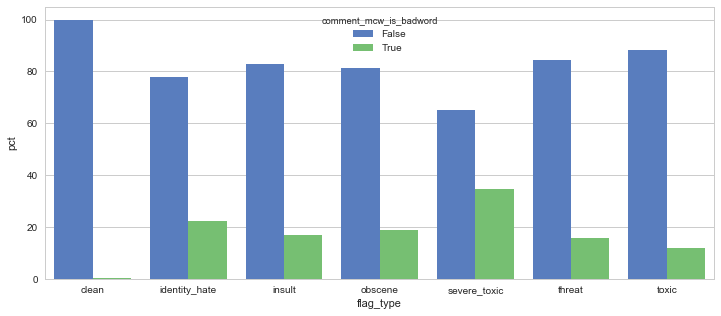

In [150]:
split = 'comment_mcw_is_badword'

q=df_melted.groupby(['flag_type',split]).size().reset_index()
q.columns = ['flag_type', split, 'size']
q=q.merge(df_melted.groupby(['flag_type']).size().reset_index())
q.columns = ['flag_type', split, 'size','total_for_flag']
q['pct'] = q['size']/q['total_for_flag']*100
plt.figure(figsize=(12,5))
sns.barplot(x='flag_type',y='pct',data=q,hue=split)

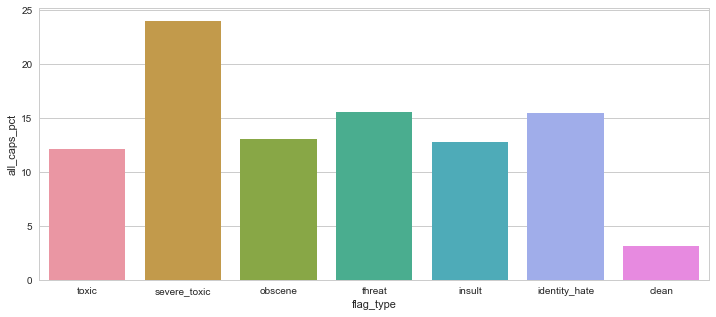

In [153]:
plt.figure(figsize=(12,5))
sns.barplot(x='flag_type',y='all_caps_pct',data=df_melted,ci=None)

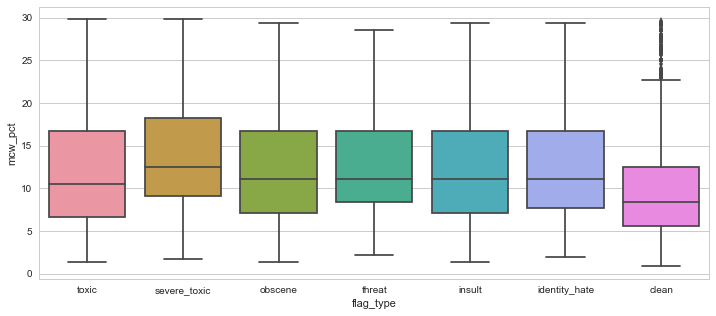

In [85]:
plt.figure(figsize=(12,5))
sns.boxplot(x='flag_type',y='mcw_pct',data=df_melted[df_melted.mcw_pct<30])

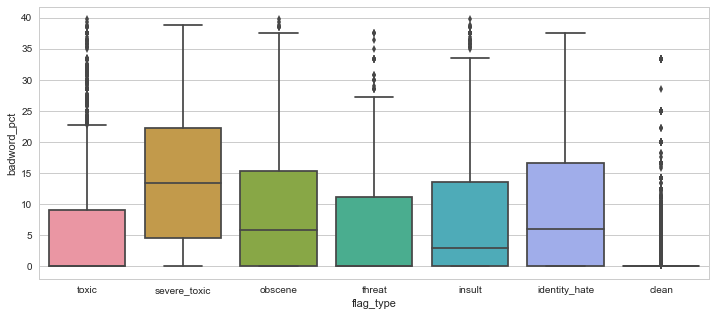

In [99]:
plt.figure(figsize=(12,5))
sns.boxplot(x='flag_type',y='badword_pct',data=df_melted[df_melted.badword_pct<40])

In [121]:
x2 = go.Histogram(x=df_melted[df_melted.flag_type=='toxic'].badword_pct,opacity=.5,name='toxic',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x5 = go.Histogram(x=df_melted[df_melted.flag_type=='severe_toxic'].badword_pct,opacity=.5,name='severe_toxic',
                  autobinx=False,histnorm='percent',xbins=dict(start=0,end=100,size=10))
x3 = go.Histogram(x=df_melted[df_melted.flag_type=='obscene'].badword_pct,opacity=.5,name='obscene',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x7 = go.Histogram(x=df_melted[df_melted.flag_type=='threat'].badword_pct,opacity=.5,name='threat',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x4 = go.Histogram(x=df_melted[df_melted.flag_type=='insult'].badword_pct,opacity=.5,name='insult',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))
x6 = go.Histogram(x=df_melted[df_melted.flag_type=='identity_hate'].badword_pct,opacity=.5,name='identity_hate',
                  autobinx=False,histnorm='percent',xbins=dict(start=0,end=100,size=10))
x1 = go.Histogram(x=df_melted[df_melted.flag_type=='clean'].badword_pct,opacity=.5,name='clean',
                  histnorm='percent',autobinx=False,xbins=dict(start=0,end=100,size=10))

data = [x1,x2,x3,x4,x5,x6]
layout = go.Layout(barmode='group',xaxis=dict(range=(0,100)))
fig = go.Figure(data=data, layout=layout)

iplot(fig)

Plot the count of flag types

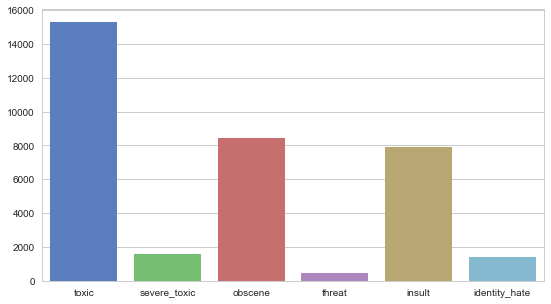

In [9]:
z = df_train_initial.loc[:,initialcols].sum()
plt.figure(figsize=(9,5))
sns.barplot(z.index,z.values)

Plot number of flags per record

why are there more triple flagged records than double flagged?

z = df_train.total_flags.value_counts()
plt.figure(figsize=(9,5))
sns.barplot(z.index,z.values,color='b')


In [10]:
z = pd.DataFrame(df_features.total_flags.value_counts())
z['flags']=z.index
iplot([go.Bar(x=z.flags,y=z.total_flags)])

Plot comment lengths

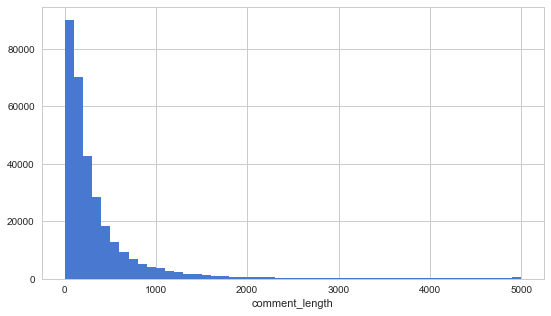

In [11]:
plt.figure(figsize=(9,5))
sns.distplot(df_features.comment_length, color='b', kde=False, hist_kws=dict(alpha=1))

sample comments

In [12]:
print('clean:\n\n',df_features[(df_features.clean==1)].iloc[1,0],'\n........................\n')
print('toxic:\n\n',df_features[(df_features.toxic==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('sever_toxic:\n\n',df_features[(df_features.severe_toxic==1)].iloc[1,0],'\n........................\n')
print('obscene:\n\n',df_features[(df_features.obscene==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('threat:\n\n',df_features[(df_features.threat==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('insult:\n\n',df_features[(df_features.insult==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('identity_hate:\n\n',df_features[(df_features.identity_hate==1)&(df_features.total_flags==1)].iloc[1,0],'\n........................\n')
print('6 flags:\n\n',df_features[(df_features.total_flags==6)].iloc[1,0],'\n........................\n')

clean:

 D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC) 
........................

toxic:

 Bye! 

Don't look, come or think of comming back! Tosser. 
........................

sever_toxic:

 Stupid peace of shit stop deleting my stuff asshole go die and fall in a hole go to hell! 
........................

obscene:

 Bleh. I'm all out of ideas. Is there really something wrong with the server or what? The damn thing won't work for me, either Helvetica_font_new.svg (my upload of Segoe UI was actually a PNG to begin with...) 
........................

threat:

 That's funny. You was personally offended? So the bad things writer new you, your name etc, right? 
And one get offended by a comment, or epithets on a website, then that same person must grow up spiritually for some more 5 centuries at least.
And if one get more offended by the previous comment, then that same person must kill him/hersef.

Take care! 
.............

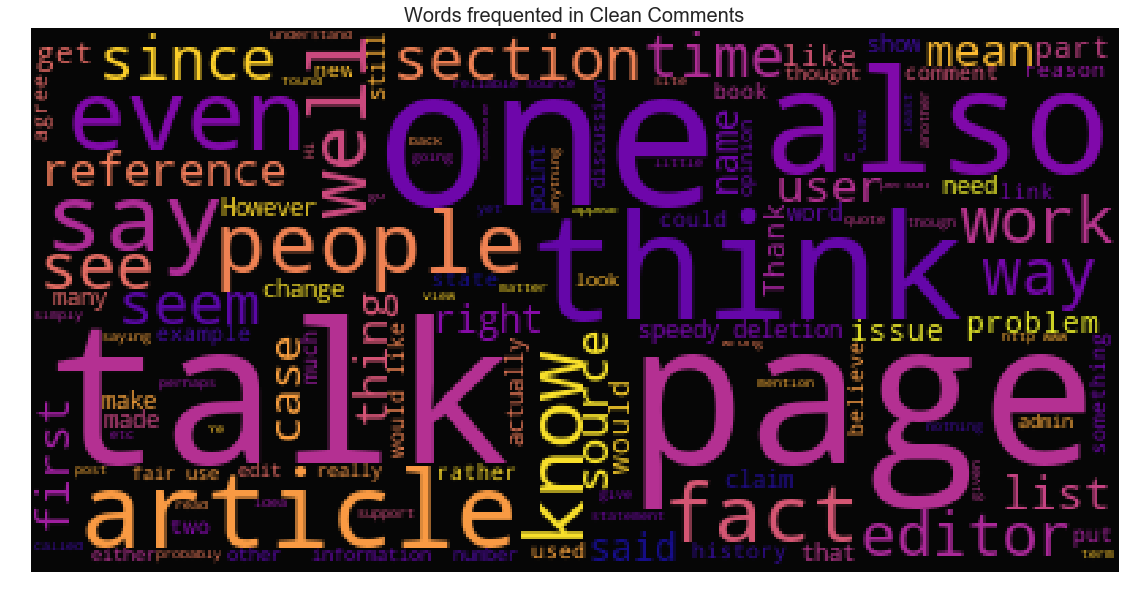

In [14]:
subset=df_features[df_features.clean==1]
text=subset.comment_text.values
wc= WordCloud(colormap='plasma',stopwords=stopwords_set)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=99), alpha=0.98)
plt.show()

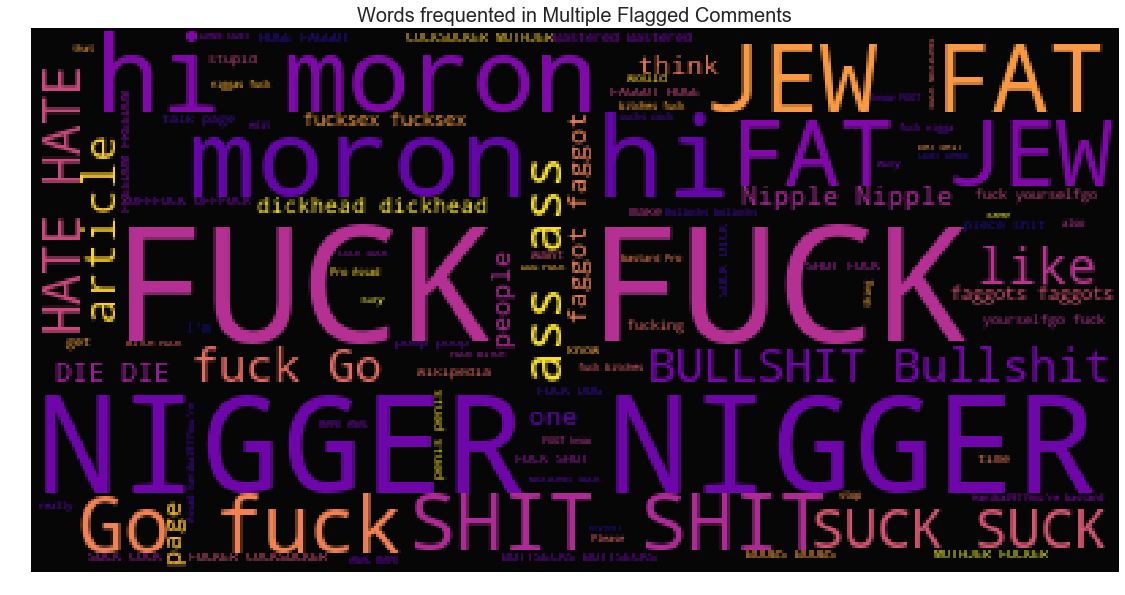

In [15]:
subset=df_features[df_features.total_flags>1]
text=subset.comment_text.values
wc= WordCloud(colormap='plasma',stopwords=stopwords_set)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Words frequented in Multiple Flagged Comments", fontsize=20)
plt.imshow(wc.recolor(random_state=99), alpha=0.98)
plt.show()